# Hyperparameter Tuning for nuT Neural Network

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
from itertools import product
import mlflow

%matplotlib inline

In [2]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.7.1 | packaged by conda-forge | (default, Feb 18 2019, 01:42:00) 
[GCC 7.3.0]
__pyTorch VERSION: 1.7.0
__CUDA VERSION
/usr/bin/sh: nvcc: command not found
__CUDNN VERSION: 7603
__Number CUDA Devices: 4
__Devices
Active CUDA Device: GPU 0
Available devices  4
Current cuda device  0


In [4]:
# Make neural network results reproducible
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

# Define Neural Network and Dataset class

In [5]:
class NutDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
 
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [6]:
class Net(nn.Module):
    def __init__(self, nInputs, nOutputs, nNeurons1, nNeurons2, activation, dropout):
        super(Net, self).__init__()
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "tanh":
            self.activation = nn.Tanh()
        elif activation == "selu":
            self.activation = nn.SELU()
        elif activation == "elu":
            self.activation = nn.ELU()
        elif activation == "celu":
            self.activation = nn.CELU()
        elif activation == "prelu":
            self.activation = nn.PReLU()
        else:
            raise ValueError("Activation function not known.")
        self.fc1 = nn.Linear(nInputs, nNeurons1) 
        self.fc2 = nn.Linear(nNeurons1, nNeurons2)
        self.fc3 = nn.Linear(nNeurons2, nOutputs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):            
        x = self.fc1(x)  
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Load and investigate data

In [7]:
# load data from hdd 
# Number of modes for U
NmU = 10 
# Number of modes for Nut
NmNut = 10


## Read the coefficients train
# U
inp_np_train_U = np.load("pytorchtrain-main/train/coeffL2U.npy")
# P
inp_np_train_P = np.load("pytorchtrain-main/train/coeffL2P.npy")
# Nut
out_np_train = np.load("pytorchtrain-main/train/coeffL2Nut.npy")
# Read Angles from file train
angles_train = np.loadtxt("pytorchtrain-main/train/angOff_mat.txt")
NOffSnap = np.load("pytorchtrain-main/train/NOffSnap.npy")
angles_train_np = []
# Fill the train angles
for k,j in enumerate(NOffSnap):
    for i in range(j):
        angles_train_np.append(angles_train[k])
angles_train_np = np.asarray(angles_train_np)

# Read the coefficients test
# U
inp_np_test_U = np.load("pytorchtrain-main/test/coeffL2U.npy")
# P
inp_np_test_P = np.load("pytorchtrain-main/test/coeffL2P.npy")
# Nut
out_np_test = np.load("pytorchtrain-main/test/coeffL2Nut.npy")
# Read Angles from file test
angles_test = np.loadtxt("pytorchtrain-main/test/angOn_mat.txt")
NOnSnap = np.load("pytorchtrain-main/test/NOnSnap.npy")
angles_test_np = []
# Fill the train angles
for k,j in enumerate(NOnSnap):
    for i in range(j):
        angles_test_np.append(angles_test[k])
angles_test_np = np.asarray(angles_test_np)

In [33]:
# currently loaded bias/scale for inp does not include angle
CONSIDER_ANGLES = True
  
if CONSIDER_ANGLES:
    X_train = np.append(np.transpose(np.expand_dims(angles_train_np,axis=0)),inp_np_train_U[:,0:NmU], axis = 1).astype("float32")
    X_test = np.append(np.transpose(np.expand_dims(angles_test_np,axis=0)),inp_np_test_U[:,0:NmU], axis = 1).astype("float32")
else:
    X_train = inp_np_train_U[:,0:NmU].astype("float32")
    X_test = inp_np_test_U[:,0:NmU].astype("float32")
    
y_train = out_np_train[:,0:NmNut].astype("float32")
y_test = out_np_test[:,0:NmNut].astype("float32")

print("X_train.shape ", X_train.shape)
print("y_train.shape ", y_train.shape)

print("X_test.shape ", X_test.shape)
print("y_test.shape ", y_test.shape)

eigenValues_y = np.loadtxt("pytorchtrain-main/Eigenvalues_nut", skiprows=2).astype("float32")
print("eigenValues_y.shape ", eigenValues_y.shape)

X_train.shape  (1400, 11)
y_train.shape  (1400, 10)
X_test.shape  (546, 11)
y_test.shape  (546, 10)
eigenValues_y.shape  (1400,)


In [34]:
def scale(inp, bias, scale):
    scaled_inp = (inp - bias) / scale
    return scaled_inp

def unscale(scaled_inp, bias, scale):
    inp = scaled_inp * scale + bias
    return inp

bias_inp = np.load("pytorchtrain-main/train/bias_inp_U.npy").flatten()[:X_train.shape[1]].astype("float32")
print("bias_inp.shape ", bias_inp.shape)
scale_inp = np.load("pytorchtrain-main/train/scale_inp_U.npy").flatten()[:X_train.shape[1]].astype("float32")
print("scale_inp.shape ", scale_inp.shape)

bias_out = np.load("pytorchtrain-main/train/bias_out.npy").flatten()[:y_train.shape[1]].astype("float32")
print("bias_out.shape ", bias_out.shape)
scale_out = np.load("pytorchtrain-main/train/scale_out.npy").flatten()[:y_train.shape[1]].astype("float32")
print("scale_out.shape ", scale_out.shape)


bias_inp.shape  (11,)
scale_inp.shape  (11,)
bias_out.shape  (10,)
scale_out.shape  (10,)


In [35]:
# scale data to [0, 1]

X_train_scaled = scale(X_train, bias_inp, scale_inp)
X_test_scaled = scale(X_test, bias_inp, scale_inp)

y_train_scaled = scale(y_train, bias_out, scale_out)
y_test_scaled = scale(y_test, bias_out, scale_out)

In [36]:
trainset = NutDataset(X_train_scaled, y_train_scaled)
testset = NutDataset(X_test_scaled, y_test_scaled)


# Inspect training data

In [37]:
columns_X = ["angle"] + ["a{}".format(i) for i in range(X_train.shape[1]-1)]
X_df = pd.DataFrame(X_train, columns=columns_X)
X_df

,angle,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9
0,0.0,0.800125,-0.239796,0.128651,-0.040402,0.025787,-0.028127,0.026359,-0.031553,0.000318,-0.004651
1,0.0,0.842396,-0.206585,0.052494,0.057183,0.061272,0.009966,0.012318,0.015486,-0.027394,-0.007727
2,0.0,0.871004,-0.167460,-0.040487,0.089516,0.000389,-0.015768,-0.037374,-0.013936,-0.012468,0.000440
3,0.0,0.884695,-0.133888,-0.096103,0.024268,-0.024983,-0.036246,0.011260,0.016532,0.002103,-0.015715
4,0.0,0.891243,-0.101186,-0.095740,-0.021276,0.001402,-0.010548,0.004129,0.011731,-0.002017,0.013542
...,...,...,...,...,...,...,...,...,...,...,...
1395,75.0,0.899474,-0.020024,0.025725,0.000505,-0.031656,0.025352,0.005711,-0.002357,-0.008937,-0.004074
1396,75.0,0.899499,-0.019746,0.025898,0.000615,-0.031675,0.025286,0.005739,-0.002334,-0.008943,-0.004043
1397,75.0,0.899518,-0.019527,0.026034,0.000700,-0.031690,0.025235,0.005760,-0.002316,-0.008948,-0.004019
1398,75.0,0.899534,-0.019355,0.026141,0.000768,-0.031702,0.025194,0.005776,-0.002303,-0.008951,-0.003999


In [38]:
X_df.describe()

,angle,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1.400000e+03,1.400000e+03
mean,39.111519,0.902165,-0.002362,0.000513,-0.000070,0.000021,-0.000041,-0.000005,-0.000002,-9.667021e-07,-6.597808e-07
std,21.326269,0.025573,0.092269,0.046044,0.024996,0.015384,0.012159,0.009717,0.007627,5.359670e-03,4.434143e-03
min,0.000000,0.799539,-0.242022,-0.096103,-0.077972,-0.064768,-0.036246,-0.061782,-0.031553,-2.739410e-02,-1.571486e-02
25%,21.428572,0.901256,-0.039393,-0.025670,-0.016392,-0.002143,-0.005422,-0.003568,-0.002811,-1.813336e-03,-2.313780e-03
50%,41.326530,0.913453,0.042105,0.015267,0.004666,-0.000576,-0.001622,0.000566,0.000226,2.805691e-04,7.667122e-04
75%,56.632652,0.915662,0.065586,0.019244,0.008693,0.006436,0.004694,0.004551,0.002174,1.944605e-03,1.847433e-03
max,75.000000,0.916646,0.077172,0.150934,0.089764,0.061910,0.038113,0.028606,0.045471,2.889649e-02,1.556416e-02


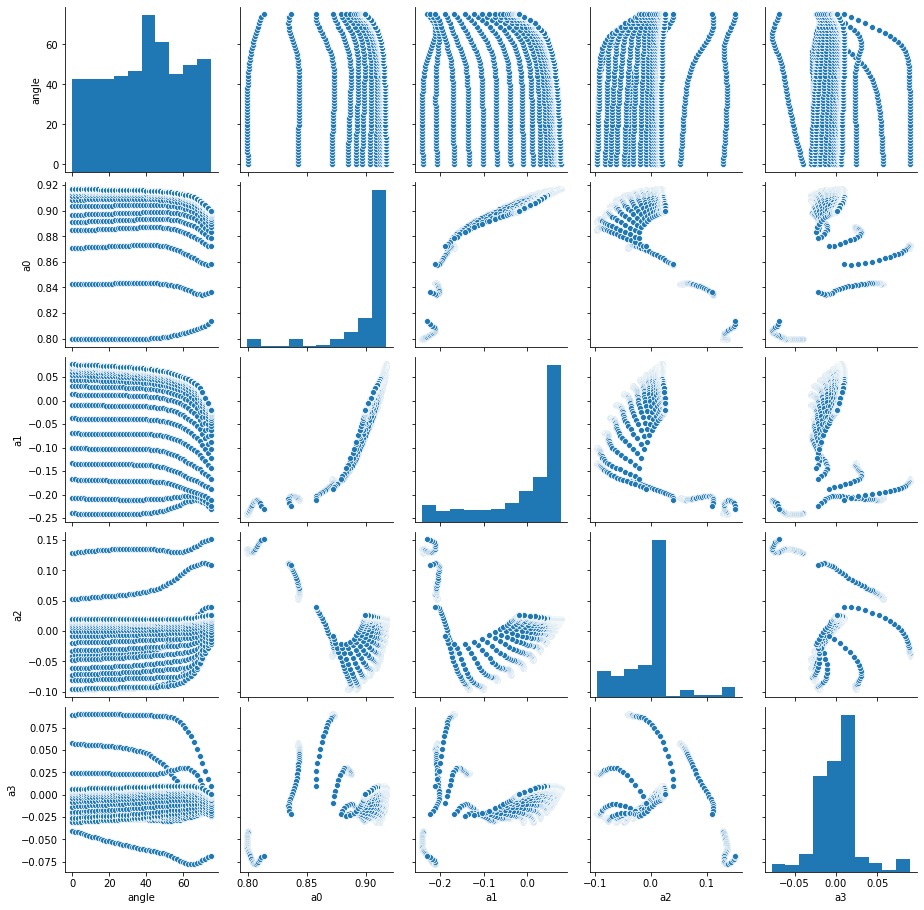

In [39]:
sns.pairplot(X_df.iloc[:, [0, 1, 2, 3, 4]])

In [40]:
y_df = pd.DataFrame(y_train, columns=["b{}".format(i) for i in range(y_train.shape[1])])
y_df

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,0.010904,-0.008352,0.000225,-0.001334,0.000337,-0.000322,0.000044,-0.000325,0.000027,-0.000007
1,0.005612,-0.003197,-0.000373,0.001787,-0.000454,-0.000649,-0.000023,0.000331,-0.000287,0.000203
2,0.003457,-0.001033,0.001982,0.002028,0.000766,0.000565,0.000495,-0.000078,-0.000442,-0.000050
3,0.003662,0.000497,0.003535,0.000625,0.000929,-0.000345,-0.000527,-0.000016,0.000209,-0.000261
4,0.004435,0.000902,0.002794,-0.000562,0.000060,0.000014,-0.000399,0.000347,-0.000173,0.000233
...,...,...,...,...,...,...,...,...,...,...
1395,0.003642,0.000860,0.000052,0.000173,-0.000096,0.000035,0.000290,-0.000131,0.000050,0.000024
1396,0.003645,0.000860,0.000048,0.000174,-0.000093,0.000035,0.000289,-0.000131,0.000050,0.000025
1397,0.003647,0.000861,0.000045,0.000176,-0.000092,0.000035,0.000289,-0.000131,0.000050,0.000025
1398,0.003649,0.000861,0.000043,0.000177,-0.000090,0.000035,0.000288,-0.000130,0.000050,0.000025


In [41]:
y_df.describe()

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1.400000e+03
mean,0.004595,0.000442,0.000106,0.000061,-0.000017,-0.000002,0.000012,-0.000005,0.000004,8.507639e-07
std,0.001361,0.001902,0.001017,0.000611,0.000341,0.000278,0.000202,0.000147,0.000132,9.451420e-05
min,0.001711,-0.008526,-0.000954,-0.001778,-0.001120,-0.000886,-0.001869,-0.001274,-0.000442,-5.096862e-04
25%,0.004116,0.000822,-0.000600,-0.000214,-0.000250,-0.000002,-0.000047,-0.000032,-0.000053,-3.898643e-05
50%,0.004607,0.001093,-0.000346,0.000066,0.000095,0.000002,-0.000012,-0.000006,0.000006,1.328372e-05
75%,0.004731,0.001115,0.000590,0.000114,0.000173,0.000012,0.000054,0.000012,0.000042,3.085509e-05
max,0.011606,0.001173,0.003535,0.002568,0.000929,0.002833,0.000749,0.001316,0.000782,4.734395e-04


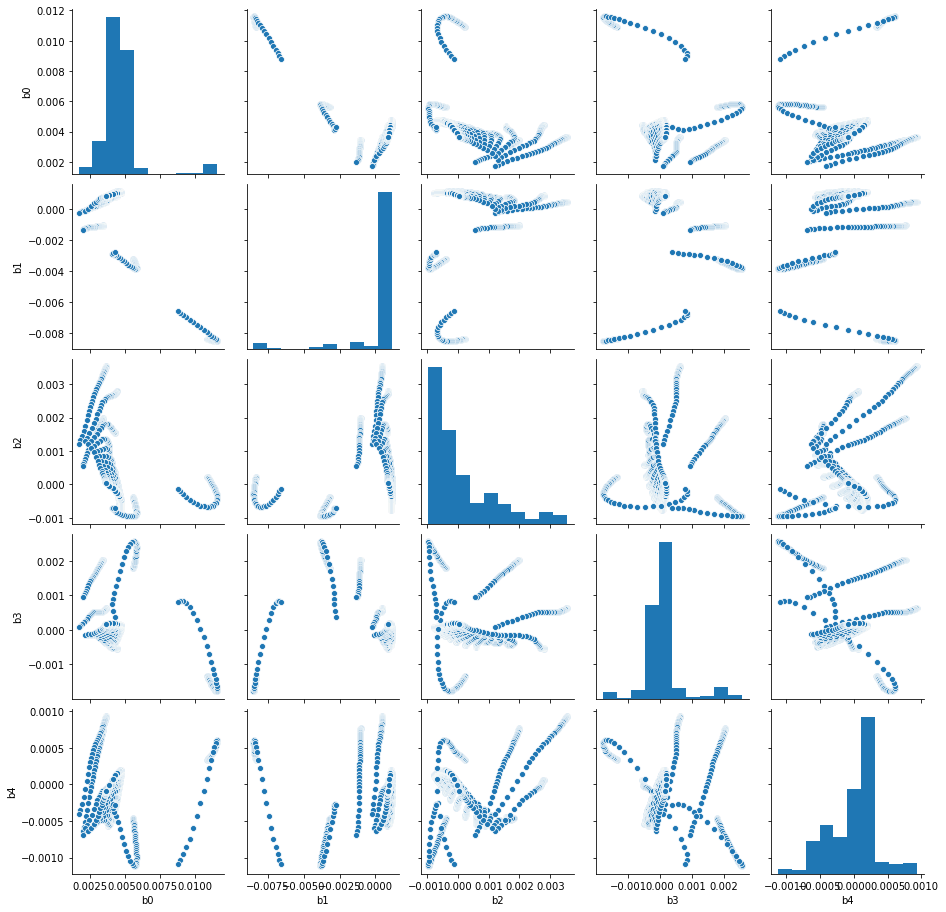

In [42]:
sns.pairplot(y_df.iloc[:, :5])

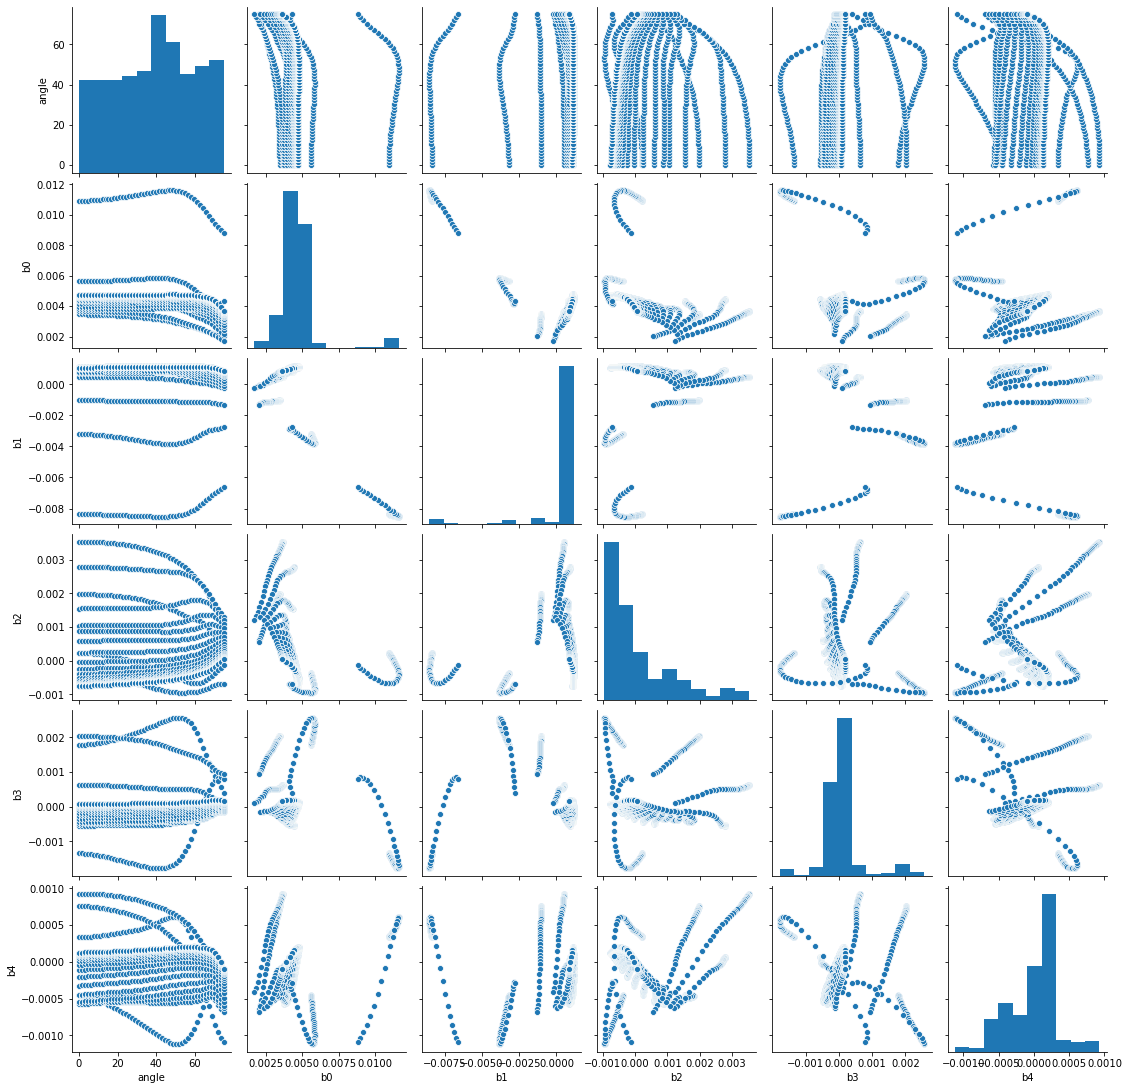

In [43]:
sns.pairplot(pd.concat([X_df.iloc[:,[0]], y_df.iloc[:, :5]], axis=1, sort=False))

# Create and optimize Neural Network

In [44]:
def get_weighted_avg_r2(r2, eigenValues):
    return (r2 * eigenValues[:len(r2)]).sum() / eigenValues[:len(r2)].sum()

In [ ]:
SEARCH = "random"
RANDOM_NUM_TRIALS = 5
PRINT_LOSS = True  

# create function in first execution, then set function (experiment appreas as seperate tab in mlflow ui); TODO detect automatically if experiment already exists
mlflow.create_experiment("round1") 
#mlflow.set_experiment("round1") 

# define hyperparameters values

hp_dict = dict(
               lr_list = [1e-3, 1e-4, 1e-5],
               nNeurons1_list = [128, 256, 512],
               nNeurons2_list = [8, 16, 32, 64, 128],
               activation_list = ["tanh", "selu"],
               epochs_list = [10000, 50000, 100000, 150000],
               batch_size_list = [128, 256, 500, 1400],
               dropout_list = [0.],
               weight_decay_list = [0., 1e-13, 1e-11, 1e-9, 1e-7, 1e-5],
               optmizer_name_list = ["Adam"])
        
hparam_values = [v for v in hp_dict.values()]


if SEARCH == "grid":
    search_iterable = product(*hparam_values)
elif SEARCH == "random":
    search_iterable = range(RANDOM_NUM_TRIALS)
else:
    raise Exception("Option for SEARCH '{}' not valid. Abort.".format(SEARCH))
    
for i, elem in enumerate(search_iterable):
    
    with mlflow.start_run():
        torch.manual_seed(0)
        np.random.seed(0)

        print("Start run {}/{}".format(i+1, len(list(search_iterable))+1))

        if SEARCH == "grid":
            lr, nNeurons1, nNeurons2, activation, epochs, batch_size, dropout, weight_decay, optimizer_name = elem
        elif SEARCH == "random":
            random_params = {k: random.sample(v, 1)[0] for k, v in hp_dict.items()}
            lr, nNeurons1, nNeurons2, activation, epochs, batch_size, dropout, weight_decay, optimizer_name = [v for v in random_params.values()]
            
        # log hps to mlflow
        mlflow.log_param("lr", lr)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)              
        mlflow.log_param("nNeurons1", nNeurons1)
        mlflow.log_param("nNeurons2", nNeurons2)
        mlflow.log_param("activation", activation)
        mlflow.log_param("dropout", dropout)
        mlflow.log_param("weight_decay", weight_decay)
        mlflow.log_param("optimizer_name", optimizer_name)
        mlflow.log_param("nInputs", X_train.shape[1])
        mlflow.log_param("nOutputs", y_train.shape[1])
        mlflow.log_param("consider_angles", CONSIDER_ANGLES)
        mlflow.log_param("consider_p_coeffs", CONSIDER_P_COEFFS)

        
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=X_test.shape[0], shuffle=True)

        net = Net(X_train.shape[1], y_train.shape[1], nNeurons1, nNeurons2, activation, dropout).to(device)

        # create your optimizer
        criterion = nn.MSELoss()
        if optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == "LBFGS":
            optimizer = optim.LBFGS(net.parameters(), lr=lr, max_iter=20)
        else:
            raise Exception()
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)
        

        NUM_EPOCHS =  epochs

        for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

            # training loop
            net.train()
            batch_losses = []
            for inputs, labels in trainloader:
                if optimizer_name == "Adam":
                    inputs, labels =  inputs.to(device), labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                elif optimizer_name == "LBFGS":
                    def closure():
                        if torch.is_grad_enabled():
                            optimizer.zero_grad()
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)
                        if loss.requires_grad:
                            loss.backward()
                        return loss
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    optimizer.step(closure)
                else:
                    raise Exception()

                batch_losses.append(loss.item())

            loss = np.mean(batch_losses)

            # evaluate accuracy on test set
            batch_test_losses = []
            batch_r2_scores_test = []
            batch_mse_test = []
            net.eval()
            with torch.no_grad():
                for inputs_test, labels_test in testloader:

                  inputs_test, labels_test =  inputs_test.to(device), labels_test.to(device)

                  outputs_test = net(inputs_test)
                  test_loss = criterion(outputs_test, labels_test)
                  batch_test_losses.append(test_loss.item())
                    
                  # rescale labels and outputs
                  labels_test_rescaled = unscale(labels_test, bias_out, scale_out)
                  outputs_test_rescaled = unscale(outputs_test, bias_out, scale_out)

                  # calculate errors metrics for each output seperately  
                  batch_r2_scores_test.append(r2_score(labels_test_rescaled, outputs_test_rescaled, multioutput="raw_values"))             
                  batch_mse_test.append(mean_squared_error(labels_test_rescaled, outputs_test_rescaled, multioutput="raw_values"))

         
            
            test_loss = np.mean(batch_test_losses)
            r2_scores_test = np.mean(batch_r2_scores_test, axis=0)
            mses_test = np.mean(batch_mse_test, axis=0)
            
            # reduce lr on plateau        
            scheduler.step(test_loss)
          
            if epoch % 20 == 0:
                # log train and val loss to mlflow (scaled data)
                mlflow.log_metric("loss_train", value=loss, step=epoch+1)
                mlflow.log_metric("loss_test", value=test_loss, step=epoch+1)

                # metrics on unscaled data
                mlflow.log_metric("weighted_avg_r2", value=get_weighted_avg_r2(r2_scores_test, eigenValues_y), step=epoch+1)
                for i, r2_score_out in enumerate(r2_scores_test):
                    mlflow.log_metric("r2_test_out{}".format(i), value=r2_score_out, step=epoch+1)

            if epoch % 999 == 0 and PRINT_LOSS:
                print('[%d]| loss: %.10f |  val loss: %.10f '  % (epoch + 1, loss, test_loss))

     
        print('Finished Training')
        print()
        # log train and val loss to mlflow (scaled data)
        mlflow.log_metric("loss_train", value=loss, step=epoch+1)
        mlflow.log_metric("loss_test", value=test_loss, step=epoch+1)

        # metrics on unscaled data
        mlflow.log_metric("weighted_avg_r2", value=get_weighted_avg_r2(r2_scores_test, eigenValues_y), step=epoch+1)
        for i, r2_score_out in enumerate(r2_scores_test):
            mlflow.log_metric("r2_test_out{}".format(i), value=r2_score_out, step=epoch+1)

        # log plots/model with mlflow    
        mlflow.pytorch.log_model(net, "models")
              
        # R2-score
        plt.plot(range(len(r2_scores_test)), r2_scores_test, '-o')
        plt.ylabel("$R^2$-score")
        plt.title("Test 1-10")
        plt.xlabel("NuT POD base coefficient no.")
        plt.xticks(range(len(r2_scores_test)))
        plt.hlines(0, -1, 11, colors='k', linestyles='dashed')
        plt.ylim(0.7, 1.05)
        plt.xlim(-1, 11)
        plt.savefig("images/r2.png", bbox_inches="tight")
        plt.close()
        
        mlflow.log_artifact("images/r2.png")
        
        # MSE 
        plt.semilogy(range(len(mses_test)), mses_test, '-o')
        plt.ylabel("MSE")
        plt.title("Test 1-10")
        plt.xlabel("NuT POD base coefficient no.")
        plt.xticks(range(len(mses_test)))
        plt.xlim(-1, 11)
        plt.savefig("images/mse.png", bbox_inches="tight")
        plt.close()
        
        mlflow.log_artifact("images/mse.png")
        
      

In [45]:
mlflow.set_experiment("round1") 

In [46]:
df = mlflow.search_runs()

In [47]:
df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.r2_test_out4,metrics.r2_test_out1,metrics.r2_test_out3,metrics.weighted_avg_r2,...,params.batch_size,params.nNeurons2,params.consider_angles,params.epochs,params.dropout,params.nInputs,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.source.name
0,05860795e3334470a54a4948427c99d8,1,FINISHED,file:///home/vw758ba/Desktop/SISSA_VW/19simple...,2020-11-19 23:13:18.697000+00:00,2020-11-19 23:22:05.770000+00:00,0.999775,0.999916,0.999812,0.999857,...,256,64,False,10000,0.0,10,vw758ba,LOCAL,"[{""run_id"": ""05860795e3334470a54a4948427c99d8""...",/home/vw758ba/.conda/envs/AI/lib/python3.7/sit...
1,acf7f96fa1a242be8ec50f62a4370d73,1,FINISHED,file:///home/vw758ba/Desktop/SISSA_VW/19simple...,2020-11-19 21:51:25.078000+00:00,2020-11-19 23:13:18.639000+00:00,0.999854,0.999938,0.999847,0.999870,...,500,16,False,100000,0.0,10,vw758ba,LOCAL,"[{""run_id"": ""acf7f96fa1a242be8ec50f62a4370d73""...",/home/vw758ba/.conda/envs/AI/lib/python3.7/sit...
2,1e8ebeb31dae4170866c28586789508c,1,FINISHED,file:///home/vw758ba/Desktop/SISSA_VW/19simple...,2020-11-19 19:02:58.906000+00:00,2020-11-19 21:51:25.020000+00:00,0.999737,0.999966,0.999919,0.999923,...,128,128,False,150000,0.0,10,vw758ba,LOCAL,"[{""run_id"": ""1e8ebeb31dae4170866c28586789508c""...",/home/vw758ba/.conda/envs/AI/lib/python3.7/sit...
3,acc6e92c79d0489db191d5d6465e6356,1,FINISHED,file:///home/vw758ba/Desktop/SISSA_VW/19simple...,2020-11-19 17:17:24.712000+00:00,2020-11-19 19:02:58.848000+00:00,0.999904,0.999966,0.999935,0.999923,...,256,128,False,100000,0.0,10,vw758ba,LOCAL,"[{""run_id"": ""acc6e92c79d0489db191d5d6465e6356""...",/home/vw758ba/.conda/envs/AI/lib/python3.7/sit...
4,f428e97429324098a9b3b2cc057a1238,1,FINISHED,file:///home/vw758ba/Desktop/SISSA_VW/19simple...,2020-11-19 16:36:03.710000+00:00,2020-11-19 17:17:24.638000+00:00,0.999737,0.999936,0.999817,0.999858,...,500,16,False,50000,0.0,10,vw758ba,LOCAL,"[{""run_id"": ""f428e97429324098a9b3b2cc057a1238""...",/home/vw758ba/.conda/envs/AI/lib/python3.7/sit...
5,506e6687cd19447893da07166f34c2af,1,FINISHED,file:///home/vw758ba/Desktop/SISSA_VW/19simple...,2020-11-19 14:46:44.897000+00:00,2020-11-19 15:38:15.748000+00:00,0.999763,0.999960,0.999878,0.999897,...,128,16,False,50000,0.0,10,vw758ba,LOCAL,"[{""run_id"": ""506e6687cd19447893da07166f34c2af""...",/home/vw758ba/.conda/envs/AI/lib/python3.7/sit...
6,5198f06fcd0a47669110224db5353c18,1,FINISHED,file:///home/vw758ba/Desktop/SISSA_VW/19simple...,2020-11-19 13:10:16.946000+00:00,2020-11-19 14:46:44.848000+00:00,0.999823,0.999968,0.999885,0.999880,...,256,32,False,100000,0.0,10,vw758ba,LOCAL,"[{""run_id"": ""5198f06fcd0a47669110224db5353c18""...",/home/vw758ba/.conda/envs/AI/lib/python3.7/sit...
7,3bc7212cc0b84aa59180b104e89ec219,1,FINISHED,file:///home/vw758ba/Desktop/SISSA_VW/19simple...,2020-11-19 12:07:01.039000+00:00,2020-11-19 13:10:16.847000+00:00,0.999869,0.999977,0.999950,0.999937,...,128,128,False,50000,0.0,10,vw758ba,LOCAL,"[{""run_id"": ""3bc7212cc0b84aa59180b104e89ec219""...",/home/vw758ba/.conda/envs/AI/lib/python3.7/sit...
8,daeb3ead413249a3bb7fc9c00322ac42,1,FINISHED,file:///home/vw758ba/Desktop/SISSA_VW/19simple...,2020-11-19 09:51:35.884000+00:00,2020-11-19 12:07:00.976000+00:00,0.999842,0.999967,0.999928,0.999937,...,500,64,False,150000,0.0,10,vw758ba,LOCAL,"[{""run_id"": ""daeb3ead413249a3bb7fc9c00322ac42""...",/home/vw758ba/.conda/envs/AI/lib/python3.7/sit...
9,08a752f83ee44d43af8e3b98e8c82694,1,FINISHED,file:///home/vw758ba/Desktop/SISSA_VW/19simple...,2020-11-19 08:26:01.824000+00:00,2020-11-19 09:51:35.832000+00:00,0.999903,0.999967,0.999843,0.999925,...,256,16,False,100000,0.0,10,vw758ba,LOCAL,"[{""run_id"": ""08a752f83ee44d43af8e3b98e8c82694""...",/home/vw758ba/.conda/envs/AI/lib/python3.7/sit...


In [48]:
df["metrics.weighted_avg_r2"].max()

0.9999666617683967

In [49]:
best_trial = df.iloc[df["metrics.weighted_avg_r2"].argmax()]
best_trial

run_id                                            3f7c47f4043c49b7aed61d323c50576a
experiment_id                                                                    1
status                                                                    FINISHED
artifact_uri                     file:///home/vw758ba/Desktop/SISSA_VW/19simple...
start_time                                        2020-11-18 18:32:14.737000+00:00
end_time                                          2020-11-18 20:34:08.981000+00:00
metrics.r2_test_out4                                                      0.999924
metrics.r2_test_out1                                                      0.999981
metrics.r2_test_out3                                                      0.999952
metrics.weighted_avg_r2                                                   0.999967
metrics.r2_test_out5                                                      0.999842
metrics.r2_test_out2                                                      0.999972
metr

# Load best model

In [50]:
run_id = best_trial["run_id"]
best_net = mlflow.pytorch.load_model("runs:/" + run_id + "/models")

best_net

Net(
  (activation): Tanh()
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

# Export best model for ITHACA

In [51]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True)
example_input, _ = next(iter(trainloader))

In [52]:
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(best_net, example_input)
traced_script_module.save("NetTorchscript.pt")